In [1]:
import numpy as np #useful for math operations
import matplotlib
import matplotlib.pyplot as plt #plotting
import seaborn as sns #pretty plots
sns.set()
sns.set_context('talk')

from scipy import integrate

#from sklearn.gaussian_process import GaussianProcessRegressor as GPR #for using Gaussian Processes
#from sklearn.gaussian_process import kernels #same
import GPy
from sklearn.preprocessing import StandardScaler #useful for scaling data

import emcee #for performing Markov Chain Monte Carlo
import corner #for plotting the posterior

In [2]:
#define our Gaussian process model
ptp = 1.
#Radial Basis Function Kernel
rbf_kern = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=ptp)
#linear kernel
lin_kern = GPy.kern.Linear(1)
#composite kernel
my_kernel = (rbf_kern)

n_pts = 200
X = np.linspace(-1, 1, n_pts).reshape(-1, 1)
Y = np.zeros(n_pts).reshape(-1, 1)
my_gp = GPy.models.GPRegression(X, Y, my_kernel)

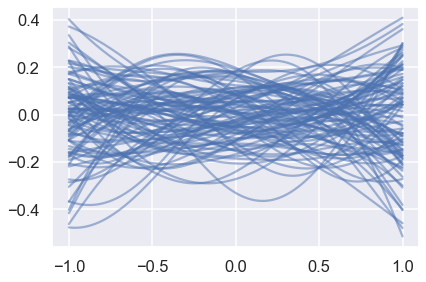

In [3]:
#draw samples from the prior
samples = my_gp.posterior_samples_f(X, full_cov=True, size=100)
for idx in range(samples.shape[2]):
    y = samples[:, 0, idx]
    plt.plot(X, y, c='b', alpha=0.5)
plt.tight_layout(True)
plt.show()

In [4]:
#Now define a model which depends on certain functionals/moments of our function
n_moments = 2
X_region = X[:100, :]

def compute_moments():
    moments = []
    samples = []    
    y = my_gp.posterior_samples_f(X, full_cov=True, size=1)
    y_f = y.flatten()
    X_f = X.flatten()
    samples.append(y_f)
    for n in range(n_moments):
        y_mom = (X_f**n) * y_f 
        val = integrate.simps(y_mom[:100], X_f[:100])
        moments.append(val)
    return moments, samples

In [5]:
#now, draw samples from the prior and compute their moments
n_samples = 1000
moments = []
samples = []
for n in range(n_samples):
    moment, sample = compute_moments()
    moments.append(moment)
    samples.append(sample)
    
moments = np.array(moments)
samples = np.array(samples)
samples = samples[:, 0, :]

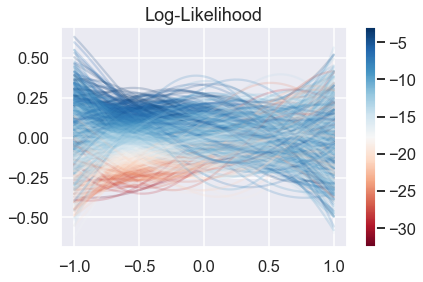

In [6]:
m_exp = 0.5
dm_exp = .1

ln_like = [-(m - m_exp)**2. / (2.* dm_exp**2.) for m in moments[:, 0]]

fig, ax = plt.subplots()
cmap = plt.cm.RdBu
norm = matplotlib.colors.Normalize(vmin=np.min(ln_like), vmax=np.max(ln_like))

for n in range(samples.shape[0]):
    plt.plot(X, samples[n, :], alpha=0.2, color=cmap(norm(ln_like[n])))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm)
plt.title('Log-Likelihood')
plt.tight_layout(True)
plt.show()